In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MaxNLocator
import matplotlib.ticker as ticker
import gymnasium as gym
import math
import mlflow
from mlflow.tracking import MlflowClient
import optuna
import os
from scipy.ndimage import gaussian_filter1d
import pandas as pd
from algorithms import *
from model_functions import *
from policy_utils import *
from experiment_result_utils import *
from constants import *
np.random.seed(constants.SEEDS[3])


In [2]:

nS = 70
uniform_restart = True
experiment_name = f"RiverSwim_{nS}_{uniform_restart}"
path = f"experiments/{experiment_name}"
if not os.path.exists(path):
    os.makedirs(path)
mlflow.set_tracking_uri(MLFLOW_URI)
experiment_id = get_or_create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)


<Experiment: artifact_location='mlflow-artifacts:/434995798545401028', creation_time=1718804351080, experiment_id='434995798545401028', last_update_time=1718804351080, lifecycle_stage='active', name='RiverSwim_70_True', tags={}>

In [3]:
results = get_parent_artifacts(experiment_id=experiment_id)
results = sorted(results, key=lambda x: x["label"])

[<Run: data=<RunData: metrics={}, params={}, tags={'batch_size': '32',
 'checkpoint_step': '1000',
 'discount_tau': 'True',
 'episodes': '7000000',
 'eps_model': '57.14285628429948',
 'exp_rate': '0.1',
 'gamma': '0.99999999',
 'lam': '1',
 'large': '1.0',
 'mlflow.runName': 'CurrQ_True',
 'mlflow.source.name': 'c:\\Users\\crist\\miniconda3\\envs\\tmdp\\lib\\site-packages\\ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'crist',
 'model_lr': '0.021651126567143412',
 'param_decay': 'True',
 'seed': '12715',
 'small': '0.005',
 'tau': '0.2',
 'test_episodes': '10000',
 'uniform_restart': 'True'}>, info=<RunInfo: artifact_uri='mlflow-artifacts:/434995798545401028/f764700ae4054de5bec57e16ee9ab6aa/artifacts', end_time=1719395220006, experiment_id='434995798545401028', lifecycle_stage='active', run_id='f764700ae4054de5bec57e16ee9ab6aa', run_name='CurrQ_True', run_uuid='f764700ae4054de5bec57e16ee9ab6aa', start_time=1719392395829, status='FINISHED', user_id='crist'>, in

Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmpkytjcwne\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=6296160, is_dir=False, path='results.pth'>, <FileInfo: file_size=41486, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmpn3ndmwn5\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=4404256, is_dir=False, path='results.pth'>, <FileInfo: file_size=28198, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmpj66r8195\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=4407840, is_dir=False, path='results.pth'>, <FileInfo: file_size=28417, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmp0m86eue4\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=3677664, is_dir=False, path='results.pth'>, <FileInfo: file_size=28115, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmp7xjwk_79\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=6298464, is_dir=False, path='results.pth'>, <FileInfo: file_size=28081, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmpfwx3hzh0\results.pth
Dictionary loaded from MLflow


In [4]:
"""results[4]["label"] = '2'"""

'results[4]["label"] = \'2\''

In [5]:
print(results[0].keys())

dict_keys(['tests_returns', 'taus', 'tests_lens', 'num_runs', 'label', 'checkpoint_step', 'uniform_restart'])


In [6]:
def plot_experiment_results(results, title=None, figsize=(6, 6), 
                            reduce:bool=False, reduced_len=None, extend:bool=False,
                            conf_int:bool=False,
                            log_scale:bool=False, 
                            moving_avg_window:int=1, ci_ma:int=1,
                            focus_range=None
                            ):
    plt.close('all')
    optimal = 1.
    rew = [r["tests_returns"] for r in results]
    if reduced_len is None:
        reduced_len = np.min([len(r[0]) for r in rew])
        reduced_len = int(reduced_len * 1.15)
    max_len = np.max([len(r[0]) for r in rew])
    fig, ax = plt.subplots(figsize=figsize)

    title = "Average Return" if title is None else title
    for i, result in enumerate(results):
        rewards = result["tests_returns"]
        label = result["label"]
        avg_rewards = np.mean(rewards, axis=0)
        if reduce:
            avg_rewards = avg_rewards[:reduced_len]
        
        # Calculate moving average
        if moving_avg_window > 1:
            avg_rewards = pd.Series(avg_rewards).rolling(window=moving_avg_window, min_periods=1).mean().values

        current_x_scale = result["checkpoint_step"]
        x_values = np.arange(len(avg_rewards)) * current_x_scale
        
        if log_scale:
            ax.set_xscale('log')
            ax.plot(x_values, avg_rewards, label=LABEL_DICT[label], c=COLORS_DICT[label], 
                    linestyle=LINE_STYLES_DICT[label],
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_LOG_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        else:
            ax.plot(x_values, avg_rewards, label=LABEL_DICT[label], c=COLORS_DICT[label],
                    linestyle=LINE_STYLES_DICT[label], 
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        
        if conf_int:
            std_dev = np.std(rewards, axis=0)
            if reduce:
                std_dev = std_dev[:reduced_len]
            
            n_samples = len(rewards)
            if moving_avg_window > 1:
                std_dev = pd.Series(std_dev).rolling(window=moving_avg_window, min_periods=1).mean().values
            std_err = std_dev / np.sqrt(n_samples)
            ci = 1.96
            upper_bound = avg_rewards + ci * std_err
            lower_bound = avg_rewards - ci * std_err
            plt.fill_between(x_values, lower_bound, upper_bound, color=COLORS_DICT[label], alpha=0.2)
    
    if optimal is not None:
        optimal_label = 'Optimal'
        ax.axhline(y=optimal, color=COLORS_DICT[optimal_label], 
                   linestyle=LINE_STYLES_DICT[optimal_label], 
                   label=optimal_label)
        ax.set_yticks(adjust_y_ticks(ax, optimal))
    ax.set_yticks(adjust_y_ticks(ax, 5e-3, True))
    
    length = max_len if not reduce else reduced_len
    length = length * current_x_scale
    
    
    if not log_scale:
        xticks_labels = generate_uniform_labels(0, length)
        ax.set_xticks(np.linspace(0, length, len(xticks_labels))) # Evenly spaced ticks
        ax.set_xticklabels(xticks_labels)
    else:
        if focus_range:
            ax.set_xlim(focus_range)
        
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_xlabel('Episodes', fontsize=20)
    ax.set_ylabel('Average Return', fontsize=20)
    ax.set_title(title, fontsize=20)
    #ax.legend(loc="best", framealpha=1.)
    plt.show()
    return fig

In [7]:
MARKER_LOG_FREQUENCY_DICT = {
    'CurrMPI': 0.22611392, 
    'CurrPMPO': 0.249415, 
    'CurrPPO': 0.2299799, 
    'CurrQ': 0.12581004, 
    'PPO': 0.2931123, 
    'Q': 0.251214,
    'Optimal': 0.68,
    '2': 0.68
}

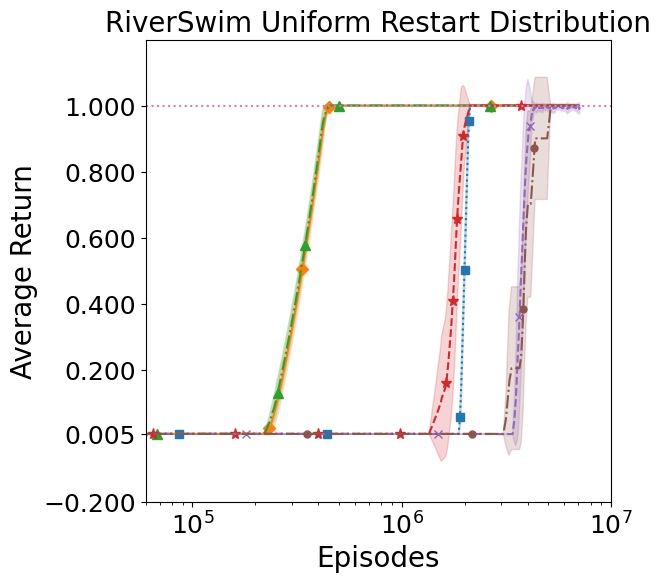

In [8]:
parts = experiment_name.split("_")
if parts[2] and uniform_restart:
    title = f"{parts[0]} Uniform Restart Distribution"
else:
    title = f"{parts[0]}"
focus_range=(6*10**4, 10**7)
fig = plot_experiment_results(results, reduce=True,
                              reduced_len=7100, 
                               conf_int=True, 
                               title=title,
                              log_scale=True, moving_avg_window=200,
                              focus_range=focus_range)

fig.savefig(f"{path}/avg_return_{experiment_name}.png", bbox_inches='tight', dpi=1000)

In [9]:
def plot_experiment_len(results, title=None, figsize=(6, 6), 
                            reduce:bool=False, reduced_len=None, extend:bool=False,
                            conf_int:bool=False, 
                            log_scale:bool=False, 
                            ci_ma:int=1, moving_avg_window:int=1,
                            sample_step:int=1,):
    plt.close('all')
    rew = [r["tests_returns"] for r in results]
    if reduced_len is None:
        reduced_len = np.min([len(r[0]) for r in rew])
        reduced_len = int(reduced_len * 1.15)
    max_len = np.max([len(r[0]) for r in rew])
    fig, ax = plt.subplots(figsize=figsize)
    
    title = r"Average Episode Length" if title is None else title
    for i, result in enumerate(results):
        if result.get("tests_lens") is None:
            print(f"Skipping {result['label']}")
            continue
        tests_lens = result["tests_lens"]
        label = result["label"]
        
        avg_tests_lens = np.mean(tests_lens, axis=0)[::sample_step]
        if reduce:
            avg_tests_lens = avg_tests_lens[:reduced_len]

        if moving_avg_window > 1:
            avg_tests_lens = pd.Series(avg_tests_lens).rolling(window=moving_avg_window, min_periods=1).mean().values
        
        current_x_scale = result["checkpoint_step"]*sample_step
        x_values = np.arange(len(avg_tests_lens)) * current_x_scale
        
        if log_scale:
            ax.set_xscale('log')
            ax.plot(x_values, avg_tests_lens, label=LABEL_DICT[label], c=COLORS_DICT[label], 
                    linestyle=LINE_STYLES_DICT[label],
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_LOG_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        else:
            ax.plot(x_values, avg_tests_lens, label=LABEL_DICT[label], c=COLORS_DICT[label],
                    linestyle=LINE_STYLES_DICT[label], 
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        
        if conf_int:
            std_dev = np.std(tests_lens, axis=0)[::sample_step]
            if reduce:
                std_dev = std_dev[:reduced_len]
            
            n_samples = len(tests_lens)
            if moving_avg_window > 1:
                std_dev = pd.Series(std_dev).rolling(window=moving_avg_window, min_periods=1).mean().values
            std_err = std_dev / np.sqrt(n_samples)
            ci = 1.96
            upper_bound = avg_tests_lens + ci * std_err
            lower_bound = avg_tests_lens - ci * std_err
            plt.fill_between(x_values, lower_bound, upper_bound, color=COLORS_DICT[label], alpha=0.2)
    
    length = max_len if not reduce else reduced_len
    length = length * current_x_scale
    ax.legend(loc="best", framealpha=1.)
    ax.set_title(title)
    if not log_scale:
        xticks_labels = generate_uniform_labels(0, length)
        ax.set_xticks(np.linspace(0, length, len(xticks_labels))) # Evenly spaced ticks
        ax.set_xticklabels(xticks_labels)
    ax.set_yticks(adjust_y_ticks(ax, 1))
    ax.set_xlabel('Episodes', fontsize=12)
    ax.set_ylabel('Episode Length', fontsize=12)
    plt.show()
    return fig

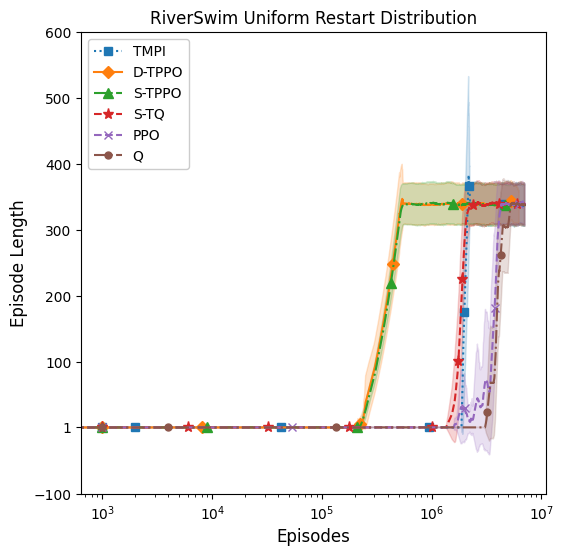

In [10]:
fig = plot_experiment_len(results, reduce=True, reduced_len=7100, 
                              title=title,
                              log_scale=True, conf_int=True, 
                              moving_avg_window=300, sample_step=1)
fig.savefig(f"{path}/avg_ep_len_{experiment_name}.png", bbox_inches='tight', dpi=1000)

In [11]:
def plot_experiment_taus(results, title=None, figsize=(6, 6), 
                            reduce:bool=False, reduced_len=None, 
                            extend:bool=False,
                            conf_int:bool=False, 
                            log_scale:bool=False, 
                            ci_ma:int=1, moving_avg_window:int=1,
                            sample_step:int=1,):
    plt.close('all')
    rew = [r["tests_returns"] for r in results]
    if reduced_len is None:
        reduced_len = np.min([len(r[0]) for r in rew])
        reduced_len = int(reduced_len * 1.15)
    
    max_len = np.max([len(r[0]) for r in rew])
    fig, ax = plt.subplots(figsize=figsize)
    title = r"Average $\tau$" if title is None else title
    
    for i, result in enumerate(results):
        label = result["label"]
        
        taus = np.array(result["taus"])
        if taus.ndim == 1:
            taus = taus[None, :]
        
        avg_taus = np.mean(taus, axis=0)[::sample_step]
        if reduce:
            avg_taus = avg_taus[:reduced_len]
        
        if moving_avg_window > 1:
            avg_taus = pd.Series(avg_taus).rolling(window=moving_avg_window, min_periods=1).mean().values
        current_x_scale = result["checkpoint_step"]*sample_step
        print(current_x_scale)
        x_values = np.arange(len(avg_taus)) * current_x_scale
        if log_scale:
            ax.set_xscale('log')
            ax.plot(x_values, avg_taus, label=LABEL_DICT[label], c=COLORS_DICT[label], 
                    linestyle=LINE_STYLES_DICT[label],
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_LOG_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        else:
            ax.plot(x_values, avg_taus, label=LABEL_DICT[label], c=COLORS_DICT[label],
                    linestyle=LINE_STYLES_DICT[label], 
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        if conf_int:
            std_dev = np.std(taus, axis=0)[::sample_step]
            if reduce:
                std_dev = std_dev[:reduced_len]
            
            n_samples = len(taus)
            if moving_avg_window > 1:
                std_dev = pd.Series(std_dev).rolling(window=moving_avg_window, min_periods=1).mean().values
            std_err = std_dev / np.sqrt(n_samples)
            ci = 1.96
            upper_bound = avg_taus + ci * std_err
            lower_bound = avg_taus - ci * std_err
            plt.fill_between(x_values, lower_bound, upper_bound, color=COLORS_DICT[label], alpha=0.2)


    length = max_len if not reduce else reduced_len
    length = length * current_x_scale
    
    ax.set_title(title)
    if not log_scale:
        print(length)
        xticks_labels = generate_uniform_labels(0, length)
        ax.set_xticks(np.linspace(0, length, len(xticks_labels))) # Evenly spaced ticks
        ax.set_xticklabels(xticks_labels)
        
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_xlabel('Episodes', fontsize=20)
    ax.set_ylabel(r'Average $\tau$', fontsize=20)
    ax.set_title(title, fontsize=20)
    #ax.legend(loc="best", framealpha=1.)
    plt.show()
    return fig

In [12]:
MARKER_LOG_FREQUENCY_DICT = {
    'CurrMPI': 0.22625492, 
    'CurrPMPO': 0.249415, 
    'CurrPPO': 0.2198799, 
    'CurrQ': 0.1261094, 
    'PPO': 0.3113503, 
    'Q': 0.251214,
    'Optimal': 0.68,
    '2': 0.68
}

1000
1000
1000
1000
1000
1000


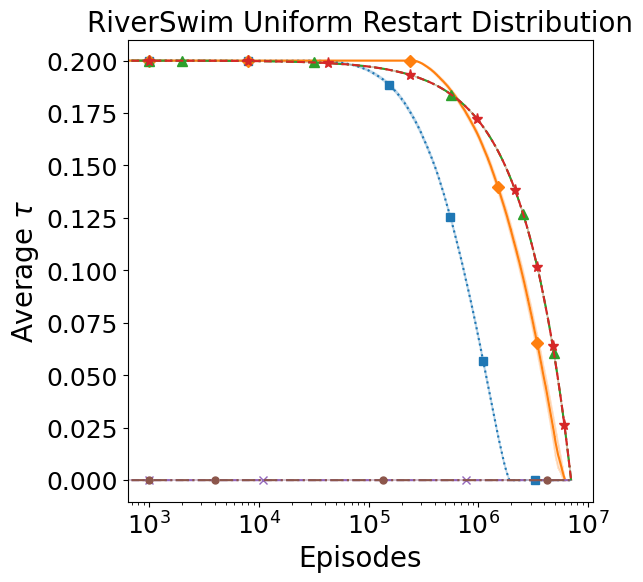

In [13]:
fig = plot_experiment_taus(results, reduce=True,
                              reduced_len=7100, 
                              title=title,
                              log_scale=True, conf_int=True, 
                              moving_avg_window=1, sample_step=1)
fig.savefig(f"{path}/avg_tau_{experiment_name}.png", bbox_inches='tight', dpi=1000)

In [14]:
def plot_experiment_gamma_eff(results, title=None, figsize=(6, 6), 
                            reduce:bool=False,reduced_len=None,
                            extend:bool=False,
                            conf_int:bool=False, 
                            log_scale:bool=False, 
                            ci_ma:int=1, moving_avg_window:int=1,
                            sample_step:int=1,):
    plt.close('all')
    rew = [r["tests_returns"] for r in results]
    if reduced_len is None:
        reduced_len = np.min([len(r[0]) for r in rew])
        reduced_len = int(reduced_len * 1.15)
    max_len = np.max([len(r[0]) for r in rew])
    fig, ax = plt.subplots(figsize=figsize)
    title = r"Average $\tau$" if title is None else title
    for i, result in enumerate(results):
        label = result["label"]
        gamma = 0.99
        
        taus = np.array(result["taus"])
        if taus.ndim == 1:
            taus = taus[None, :]

        gamma_eff = (1-taus)*gamma
        avg_gamma_eff = np.mean(gamma_eff, axis=0)[::sample_step]
        if reduce:
            avg_gamma_eff = avg_gamma_eff[:reduced_len]
        current_x_scale = result["checkpoint_step"]
        x_values = np.arange(len(avg_gamma_eff)) * current_x_scale*sample_step
        
        if log_scale:
            ax.set_xscale('log')
            ax.plot(x_values, avg_gamma_eff, label=LABEL_DICT[label], c=COLORS_DICT[label], 
                    linestyle=LINE_STYLES_DICT[label],
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_LOG_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        else:
            ax.plot(x_values, avg_gamma_eff, label=LABEL_DICT[label], c=COLORS_DICT[label],
                    linestyle=LINE_STYLES_DICT[label], 
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        if conf_int:
            std_dev = np.std(gamma_eff, axis=0)[::sample_step]
            if reduce:
                std_dev = std_dev[:reduced_len]
            
            n_samples = len(gamma_eff)
            if moving_avg_window > 1:
                std_dev = pd.Series(std_dev).rolling(window=moving_avg_window, min_periods=1).mean().values
            std_err = std_dev / np.sqrt(n_samples)
            ci = 1.96
            upper_bound = avg_gamma_eff + ci * std_err
            lower_bound = avg_gamma_eff - ci * std_err
            plt.fill_between(x_values, lower_bound, upper_bound, color=COLORS_DICT[label], alpha=0.2)

    length = max_len if not reduce else reduced_len
    length = length * current_x_scale
    ax.legend(loc="best", framealpha=1.)
    ax.set_title(title)
    if not log_scale:
        xticks_labels = generate_uniform_labels(0, length)
        ax.set_xticks(np.linspace(0, length, len(xticks_labels))) # Evenly spaced ticks
        ax.set_xticklabels(xticks_labels)
        
    ax.set_xlabel('Episodes', fontsize=12)
    ax.set_ylabel(r'Average $\gamma_{eff}$', fontsize=12)
    plt.show()
    return fig, ax

In [15]:
MARKER_LOG_FREQUENCY_DICT = {
    'CurrMPI': 0.22584192, 
    'CurrPMPO': 0.249415, 
    'CurrPPO': 0.2198799, 
    'CurrQ': 0.1261094, 
    'PPO': 0.3113503, 
    'Q': 0.251214,
    'Optimal': 0.68,
    '2': 0.68
}

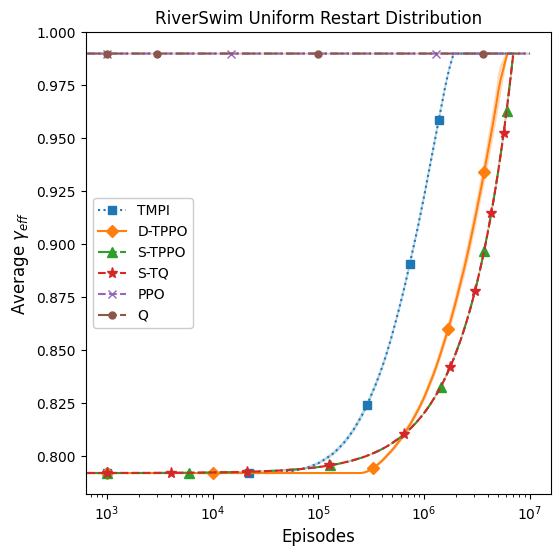

In [16]:
fig, ax = plot_experiment_gamma_eff(results, reduce=False, 
                                reduced_len=7100, 
                              title=title,
                              log_scale=True, conf_int=True, 
                              moving_avg_window=10, sample_step=1)
fig.savefig(f"{path}/avg_gamma_eff_{experiment_name}.png", bbox_inches='tight', dpi=1000)

In [17]:
def save_legend(fig, ax, filename='legend_only.png'):
    fig_legend = plt.figure(figsize=(8, 1))
    ax_legend = fig_legend.add_subplot(111)
    ax_legend.axis('off')
    handles, labels = ax.get_legend_handles_labels()
    fig_legend.legend(handles, labels, loc='center', ncol=len(labels), frameon=False)
    fig_legend.savefig(filename, bbox_inches='tight', dpi=1000, pad_inches=0)
    plt.close(fig_legend)

In [18]:
save_legend(fig, ax)